In [2]:
from IPython.display import HTML
from IPython.display import Image
import webbrowser 

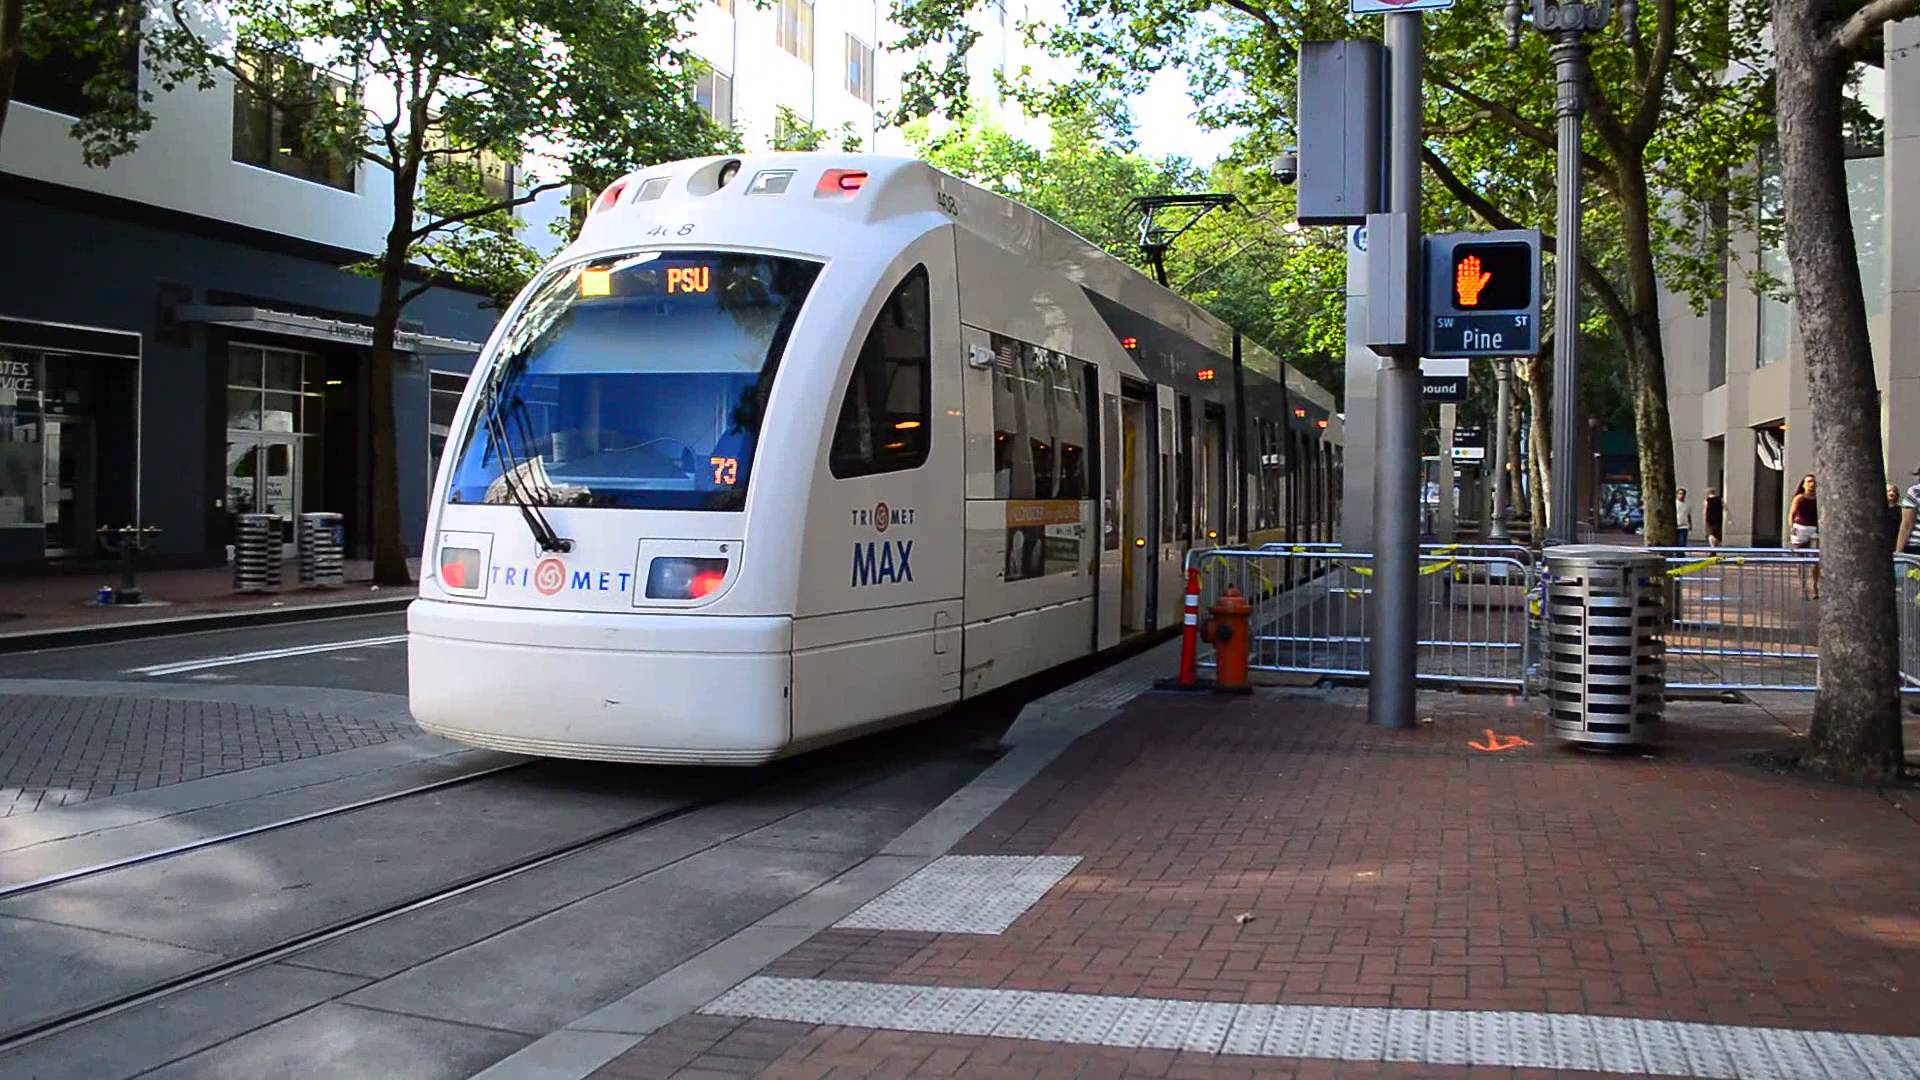

In [3]:
Image("maxresdefault.jpg")

Pieter Leffers


Rutherford Brakke-Pound

Michelle Bird

Bruce Irvin

Maria Ji

Omar Ahmed

Justin Wiley

Project: Portland Trimet Data
=================

In [374]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

Redfin Housing Data
-----------------

In [45]:
url='https://www.redfin.com/blog/data-center'
#webbrowser.open(url)

In [4]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Housing/'
housing=pd.read_csv(location+'housing.csv',delimiter=',')
housing.head()

,Avg Sale To List,Avg Sale To List Mom,Avg Sale To List Yoy,Homes Sold,Homes Sold Mom,Homes Sold Yoy,Inventory,Inventory Mom,Inventory Yoy,Median Dom,...,Median Dom Yoy,Median Sale Price,Median Sale Price Mom,Median Sale Price Yoy,New Listings,New Listings Mom,New Listings Yoy,Period End,Property Type,Region
0,0.985435,-0.50%,-0.10%,8,14.30%,14.30%,9.0,50.00%,28.60%,44.5,...,20.0,$398K,-7.60%,-33.20%,11,10.00%,-15.40%,4/30/2018,All Residential,"Portland, OR - Sullivan's Gulch"
1,0.984077,-0.70%,-0.40%,13,-7.10%,333.30%,11.0,-26.70%,-26.70%,18.0,...,0.5,$156K,-0.50%,9.90%,11,-8.30%,120.00%,12/31/2012,All Residential,"Portland, OR - Lents-Powellhurst-Gilbert"
2,0.987811,1.00%,0.50%,28,16.70%,154.50%,5.0,-54.50%,-68.80%,33.0,...,-30.0,$271K,8.10%,-1.60%,10,-54.50%,0.00%,12/31/2012,All Residential,"Portland, OR - South Tabor"
3,1.042150,1.80%,4.60%,24,20.00%,33.30%,10.0,-9.10%,-23.10%,17.0,...,-6.0,$248K,1.00%,11.40%,25,4.20%,92.30%,7/31/2015,All Residential,"Portland, OR - Parkrose"
4,1.080477,5.40%,9.30%,7,0.00%,-12.50%,1.0,0.00%,-92.90%,5.0,...,-2.0,$550K,13.40%,69.00%,6,-25.00%,-78.60%,7/31/2015,All Residential,"Portland, OR - Eliot"


In [5]:
housing.columns

Index(['Avg Sale To List', 'Avg Sale To List Mom', 'Avg Sale To List Yoy',
       'Homes Sold', 'Homes Sold Mom', 'Homes Sold Yoy', 'Inventory',
       'Inventory Mom', 'Inventory Yoy', 'Median Dom', 'Median Dom Mom',
       'Median Dom Yoy', 'Median Sale Price', 'Median Sale Price Mom',
       'Median Sale Price Yoy', 'New Listings', 'New Listings Mom',
       'New Listings Yoy', 'Period End', 'Property Type', 'Region'],
      dtype='object')

In [6]:
housing.sort_values(by='Period End',ascending=False).head()

,Avg Sale To List,Avg Sale To List Mom,Avg Sale To List Yoy,Homes Sold,Homes Sold Mom,Homes Sold Yoy,Inventory,Inventory Mom,Inventory Yoy,Median Dom,...,Median Dom Yoy,Median Sale Price,Median Sale Price Mom,Median Sale Price Yoy,New Listings,New Listings Mom,New Listings Yoy,Period End,Property Type,Region
3108,0.996688,0.70%,0.00%,62,-1.60%,-11.40%,45.0,-8.20%,-16.70%,25.0,...,10.0,$387K,-1.90%,6.80%,57,-14.90%,-23.00%,9/30/2017,All Residential,"Portland, OR - Pleasant Valley"
7115,0.991426,-0.40%,-2.80%,12,33.30%,20.00%,9.0,-30.80%,28.60%,34.5,...,30.5,$487K,-8.90%,7.80%,19,11.80%,58.30%,9/30/2017,All Residential,"Portland, OR - South Burlingame"
4757,1.010670,-1.10%,-1.50%,28,-22.20%,-17.60%,25.0,-26.50%,47.10%,9.0,...,2.0,$475K,2.70%,2.50%,55,-3.50%,66.70%,9/30/2017,All Residential,"Portland, OR - Overlook"
135,1.017708,1.00%,-0.40%,13,-7.10%,44.40%,7.0,-50.00%,0.00%,5.5,...,-5.5,$605K,7.80%,16.30%,8,-57.90%,-42.90%,9/30/2017,All Residential,"Portland, OR - Eliot"
6420,0.994858,-1.40%,0.00%,25,19.00%,0.00%,17.0,-10.50%,54.50%,18.0,...,-2.0,$805K,2.00%,24.00%,27,-22.90%,35.00%,9/30/2017,All Residential,"Portland, OR - Laurelhurst"


In [7]:
print('The starting date for housing prices in the dataset is',housing['Period End'].min())

The starting date for housing prices in the dataset is 1/31/2012


In [8]:
print('The ending date for housing prices in the dataset is',housing['Period End'].max())

The ending date for housing prices in the dataset is 9/30/2017


In [9]:
housing['Region'].unique()
houseHoods=housing['Region'].unique().copy()
houseHoods[:15]

array(["Portland, OR - Sullivan's Gulch",
       'Portland, OR - Lents-Powellhurst-Gilbert',
       'Portland, OR - South Tabor', 'Portland, OR - Parkrose',
       'Portland, OR - Eliot', 'Portland, OR - Kerns',
       'Portland, OR - Argay', 'Portland, OR - Multnomah Village',
       'Portland, OR - Lents', 'Portland, OR - North Tabor',
       'Portland, OR - Hillside', 'Portland, OR - Cully',
       'Portland, OR metro area', 'Portland, OR - Brentwood',
       'Portland, OR - Downtown Portland'], dtype=object)

In [10]:
def scrubadub(variable):
    myList=(list(variable))
    clean=[]
    for i in range(0,len(myList)):
        #Regular expressions for removing web addresses
        url_reg  = r'[a-z]*[:.]+\S+|Portland|OR'
        #and replacing with nothing
        url_text=re.sub(url_reg, '', myList[i])
        sep = " "
        junk = re.findall(r"(?i)\b[a-z]+\b", url_text)
        #join the seperated words
        junk = sep.join(junk)
        #remove _s_ spaces from text after punctuation removal
        S_space = re.sub(r' s ','',junk)
        clean.append(S_space)
    return clean

Matching Regions / Neighborhoods

In [11]:
Hood=scrubadub(housing['Region'])
housing['Hood']=Hood
housing[['Region','Hood']].head(n=15)

,Region,Hood
0,"Portland, OR - Sullivan's Gulch",SullivanGulch
1,"Portland, OR - Lents-Powellhurst-Gilbert",Lents Powellhurst Gilbert
2,"Portland, OR - South Tabor",South Tabor
3,"Portland, OR - Parkrose",Parkrose
4,"Portland, OR - Eliot",Eliot
5,"Portland, OR - Kerns",Kerns
6,"Portland, OR - Argay",Argay
7,"Portland, OR - Multnomah Village",Multnomah Village
8,"Portland, OR - Lents",Lents
9,"Portland, OR - North Tabor",North Tabor


Text(0,0.5,'Median Cost of Houses by Neighborhood')

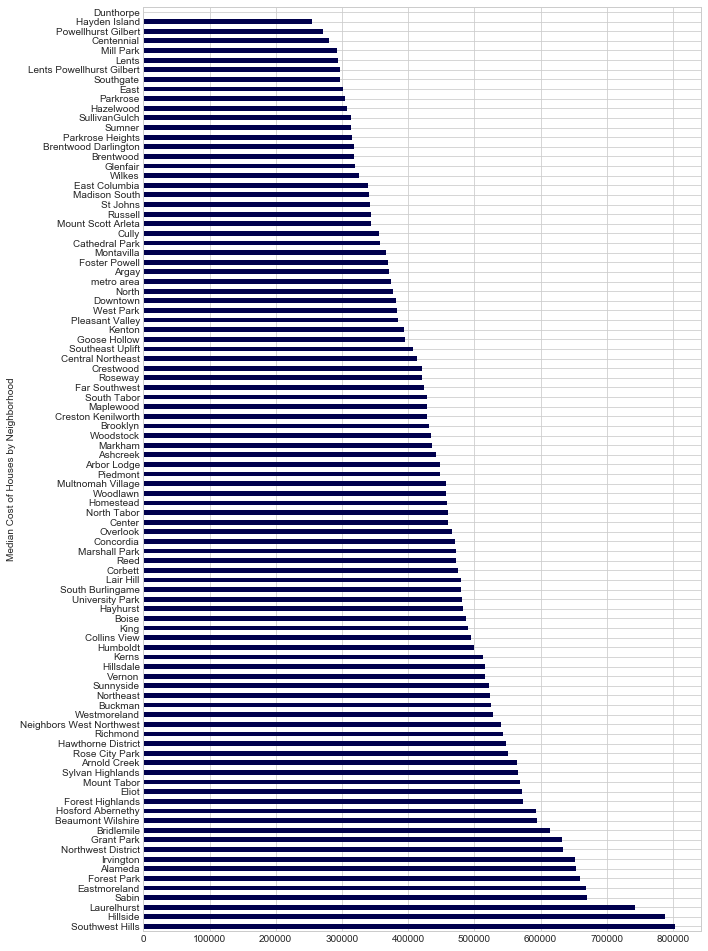

In [12]:
houseReduce=housing[['Period End','Region','Hood','Median Sale Price']].copy() #create a new dataframe
houseReduce.rename(index=str,columns={"Period End": "PeriodEnd"},inplace=True) #rename column for ease
houseReduce.rename(index=str,columns={"Median Sale Price": "MedSale_Price"},inplace=True) #rename column for ease
houseReduce['MedSale_Price']=houseReduce.MedSale_Price.str.replace('$','').str.replace('K','000') #replace $ and K
houseReduce['MedSale_Price']=pd.to_numeric(houseReduce.MedSale_Price,errors='coerce') # Make the column numeric
houseReduce['PeriodEnd']=pd.to_datetime(houseReduce.PeriodEnd) #Change time element to datetime
houseReduce.sort_values(by='PeriodEnd',ascending=True,inplace=True)
houseReduce=houseReduce[6592:7077].copy() # Get time frame to match 911 Call time period (9/9/2017 - 1/1/2018)
#This only needs to be approximate in order to get a sense of housing values at the time
houseReduce.reset_index(drop=True,inplace=True)# resetting the index
houseReduce['ones']=1
houseReduce_GB=houseReduce.groupby(houseReduce['Hood']).sum()
houseReduce_GB['MedSale_Price']=houseReduce_GB.MedSale_Price/5 #five observations per neighborhood in timescale
#houseReduce_GB.iloc[1:,:1]

houseReduce_GB.iloc[1:,:1].sort_values(by='MedSale_Price',ascending=False).plot(kind='barh',figsize=(10,17),cmap='seismic',legend=False)
plt.ylabel('Median Cost of Houses by Neighborhood')

In [13]:
houseReduce_GB=houseReduce_GB.iloc[1:,:1].reset_index()
houseHoods=houseReduce_GB['Hood'].unique()
houseHoods

array(['Alameda', 'Arbor Lodge', 'Argay', 'Arnold Creek', 'Ashcreek',
       'Beaumont Wilshire', 'Boise', 'Brentwood', 'Brentwood Darlington',
       'Bridlemile', 'Brooklyn', 'Buckman', 'Cathedral Park', 'Centennial',
       'Center', 'Central Northeast', 'Collins View', 'Concordia',
       'Corbett', 'Creston Kenilworth', 'Crestwood', 'Cully', 'Downtown',
       'Dunthorpe', 'East', 'East Columbia', 'Eastmoreland', 'Eliot',
       'Far Southwest', 'Forest Highlands', 'Forest Park', 'Foster Powell',
       'Glenfair', 'Goose Hollow', 'Grant Park', 'Hawthorne District',
       'Hayden Island', 'Hayhurst', 'Hazelwood', 'Hillsdale', 'Hillside',
       'Homestead', 'Hosford Abernethy', 'Humboldt', 'Irvington', 'Kenton',
       'Kerns', 'King', 'Lair Hill', 'Laurelhurst', 'Lents',
       'Lents Powellhurst Gilbert', 'Madison South', 'Maplewood',
       'Markham', 'Marshall Park', 'Mill Park', 'Montavilla',
       'Mount Scott Arleta', 'Mount Tabor', 'Multnomah Village',
       'Neighbors 

911 Calls
-------------

In [14]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
trimCalls=pd.read_csv(location+'trimet-calls.csv',delimiter=',')
trimCalls.head()

,Unnamed: 0,Call Number,Call Category,Call Group,Neighborhood,Report Date,Response Time (sec),Time In Queue (sec),Travel Time (sec)
0,0,2296401412,TriMet,Disorder,Hosford-Abernethy,7/4/2017 8:33:30 PM,42.0,42.0,0.0
1,1,2392175033,TriMet,Disorder,Hosford-Abernethy,12/18/2017 7:13:27 PM,692.0,49.0,643.0
2,2,2570595016,TriMet,Disorder,Hosford-Abernethy,4/8/2018 10:25:38 AM,2193.0,1156.0,1037.0
3,3,2188786224,TriMet,Disorder,Powellhurst-Gilbert,9/2/2017 8:55:42 AM,1140.0,1003.0,137.0
4,4,2309187422,TriMet,Disorder,Foster-Powell,8/5/2017 12:03:42 PM,797.0,90.0,707.0


In [15]:
trimCalls.sort_values(by='Report Date',ascending=False,inplace=True)

In [16]:
trimCalls.head(n=3)

,Unnamed: 0,Call Number,Call Category,Call Group,Neighborhood,Report Date,Response Time (sec),Time In Queue (sec),Travel Time (sec)
3742,3742,2205590944,TriMet,Disorder,Lloyd,9/9/2017 7:17:03 PM,462.0,54.0,408.0
3815,3815,2205507216,TriMet,Disorder,Sullivan's Gulch,9/9/2017 6:39:11 PM,1150.0,811.0,339.0
122,122,2319828442,TriMet,Disorder,Downtown,9/9/2017 2:19:42 PM,212.0,25.0,187.0


In [17]:
trimCalls.tail(n=3)

,Unnamed: 0,Call Number,Call Category,Call Group,Neighborhood,Report Date,Response Time (sec),Time In Queue (sec),Travel Time (sec)
1428,1428,2415974432,TriMet,Disorder,NaN,1/1/2018 11:01:41 AM,610.0,131.0,479.0
2576,2576,2416892064,TriMet,Disorder,Kenton,1/1/2018 10:36:30 PM,240.0,77.0,163.0
2382,2382,2415649842,TriMet,Disorder,Powellhurst-Gilbert,1/1/2018 10:24:42 AM,257.0,50.0,207.0


In [18]:
print('The first observation of the dataset started on date',trimCalls['Report Date'].max())
print('The last observation of the dataset ended on date',trimCalls['Report Date'].min())

The first observation of the dataset started on date 9/9/2017 7:17:03 PM
The last observation of the dataset ended on date 1/1/2018 10:24:42 AM


Text(0,0.5,'Counts of 911 Calls per Neighborhood')

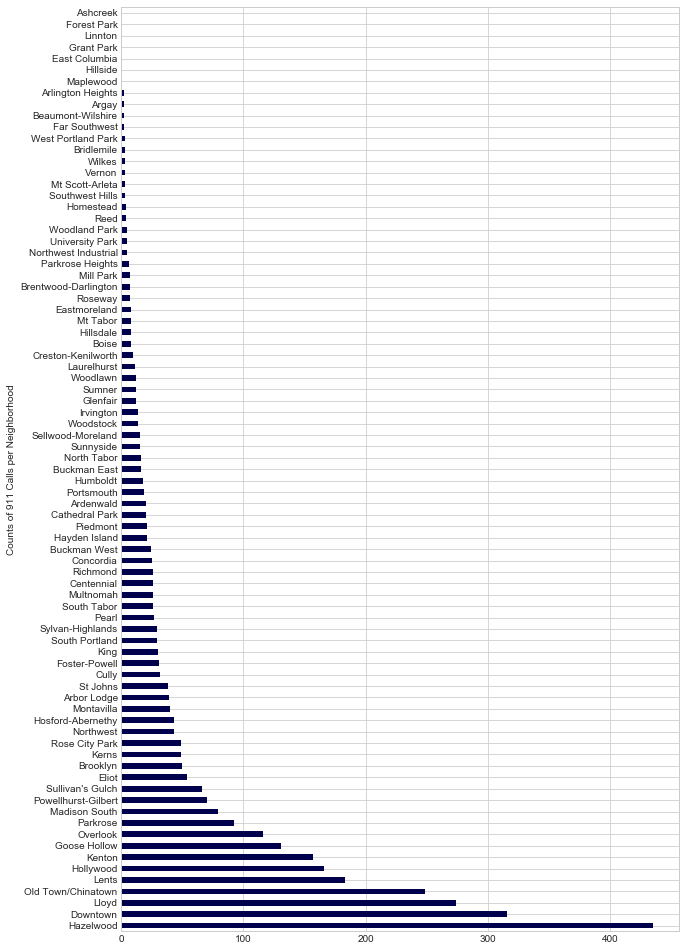

In [19]:
subcatCounts=pd.Series(trimCalls.Neighborhood).value_counts()
subcatCounts.plot(kind='barh',figsize=(10,17),cmap='seismic',legend=False)
plt.ylabel('Counts of 911 Calls per Neighborhood')

In [20]:
SubCalls=pd.DataFrame(subcatCounts)
SubCalls.reset_index(inplace=True)
SubCalls.columns=(['Hood','CallCount'])
SubCalls.head()

,Hood,CallCount
0,Hazelwood,435
1,Downtown,316
2,Lloyd,274
3,Old Town/Chinatown,249
4,Lents,183


In [21]:
callHoods=trimCalls['Neighborhood'].unique().copy()
callHoods=pd.DataFrame(callHoods,columns=['CallHoods'])
callHoods.fillna('missing',inplace=True) #replace Missings
callHoods[:10]

,CallHoods
0,Lloyd
1,Sullivan's Gulch
2,Downtown
3,Ardenwald
4,Cully
5,Humboldt
6,Overlook
7,Old Town/Chinatown
8,Hazelwood
9,Hosford-Abernethy


In [22]:
len(callHoods)

82

In [23]:
houseHoods=pd.DataFrame(houseHoods,columns=['HouseHoods'])
houseHoods.fillna('missing',inplace=True)
houseHoods[:10]

,HouseHoods
0,Alameda
1,Arbor Lodge
2,Argay
3,Arnold Creek
4,Ashcreek
5,Beaumont Wilshire
6,Boise
7,Brentwood
8,Brentwood Darlington
9,Bridlemile


In [24]:
len(houseHoods)

96

*Here we can get a quick view of the neighborhood differences between Redfin data and 911 call data*

In [25]:
houseHoodsSET=set(houseHoods.HouseHoods)#Creating SETs will automatically make unique units
SubCallsSET=set(SubCalls.Hood)

In [26]:
SubCallsSET.difference(houseHoodsSET) #Executing DIFFERENCE returns the differenes between two SETs

{'Ardenwald',
 'Arlington Heights',
 'Beaumont-Wilshire',
 'Brentwood-Darlington',
 'Buckman East',
 'Buckman West',
 'Creston-Kenilworth',
 'Foster-Powell',
 'Hollywood',
 'Hosford-Abernethy',
 'Linnton',
 'Lloyd',
 'Mt Scott-Arleta',
 'Mt Tabor',
 'Multnomah',
 'Northwest',
 'Northwest Industrial',
 'Old Town/Chinatown',
 'Pearl',
 'Portsmouth',
 'Powellhurst-Gilbert',
 'Sellwood-Moreland',
 'South Portland',
 "Sullivan's Gulch",
 'Sylvan-Highlands',
 'West Portland Park',
 'Woodland Park'}

In [27]:
#Handy piece of code! 
def concatenate_list_data(list): 
    '''
    Concatenates all strings/objects in the list. 
    This is especially nice when paired with regular expressions.
    '''
    result= ''
    for element in list:
        result += str(element)
    return result

Matches Housing Neighborhoods to 911 dataset

In [28]:
SubCalls.head()

,Hood,CallCount
0,Hazelwood,435
1,Downtown,316
2,Lloyd,274
3,Old Town/Chinatown,249
4,Lents,183


Create expressions to use for matching

In [29]:
matchExpr=[]
for i in range(0,len(houseHoods.HouseHoods)):
    matchExpr.append(str(houseHoods.HouseHoods[i][:6])+'.*|')#take the first 6 characters of the strings, 
    #                                                with all luck 6 characters are enough to make them unique
matchExpr=concatenate_list_data(matchExpr)
print('List of regular expressions using first 6 characters of neighborhoods: \n'+matchExpr[:80]+'...etc.')

List of regular expressions using first 6 characters of neighborhoods: 
Alamed.*|Arbor .*|Argay.*|Arnold.*|Ashcre.*|Beaumo.*|Boise.*|Brentw.*|Brentw.*|B...etc.


Identify matches

In [30]:
# For loop to check if any of the neighborhoods match the list of regular expressions created
matchList=[]
for i in range(0,len(SubCalls.Hood)):
    identify=re.findall(r'('+matchExpr+')',SubCalls.Hood[i])
    if identify[0]==SubCalls.Hood[i]:
        matchList.append('1')
    else:
        matchList.append('0')

Showing Neighborhoods that don't match. These results mostly corraborate the results previously showing the differences between the two datasets. The benefit here is we used regular expressions to identify more matches and can manipulate the data a little easier in this format.

In [31]:
SubCalls['CallMatches']=matchList
SubCalls.sort_values(by='Hood',inplace=True)
SubCalls[SubCalls['CallMatches']!='1']

,Hood,CallCount,CallMatches
37,Ardenwald,20,0
73,Arlington Heights,2,0
5,Hollywood,166,0
78,Linnton,1,0
2,Lloyd,274,0
65,Mt Scott-Arleta,3,0
53,Mt Tabor,8,0
3,Old Town/Chinatown,249,0
27,Pearl,27,0
38,Portsmouth,19,0


In [32]:
SubCalls.CallMatches.value_counts()

1    70
0    11
Name: CallMatches, dtype: int64

In [33]:
#Data Cleaning for best matching, a few more can be modified to increase the number of matches

houseReduce_GB.replace('SullivanGulch',"Sullivan's Gulch",inplace=True)
houseReduce_GB.replace('Beaumont Wilshire','Beaumont-Wilshire',inplace=True)
houseReduce_GB.replace('Mount Scott Arleta','Mt Scott-Arleta',inplace=True)
houseReduce_GB.replace('Mount Tabor','Mt Tabor',inplace=True)
houseReduce_GB.replace('Westmoreland','Sellwood-Moreland',inplace=True)
#Merge datasets
DataReduce=houseReduce_GB.merge(SubCalls,how='left',on='Hood')

In [34]:
DataReduce[DataReduce['CallCount']>0].sort_values(by='CallCount').tail(n=20)

,Hood,MedSale_Price,CallCount,CallMatches
13,Centennial,280600.0,26.0,1
79,South Tabor,428000.0,26.0,1
47,King,491000.0,30.0,1
21,Cully,355200.0,32.0,1
83,St Johns,341600.0,38.0,1
1,Arbor Lodge,447400.0,39.0,1
57,Montavilla,366000.0,40.0,1
74,Rose City Park,550600.0,49.0,1
46,Kerns,512800.0,49.0,1
10,Brooklyn,431000.0,50.0,1


In [35]:
#DataReduce=DataReduce[DataReduce['CallCount']>0]
DataReduce=DataReduce[['Hood','MedSale_Price','CallCount']]
#DataReduce.set_index('Hood',inplace=True)

In [36]:
DataReduce.head()

,Hood,MedSale_Price,CallCount
0,Alameda,653200.0,NaN
1,Arbor Lodge,447400.0,39.0
2,Argay,370800.0,2.0
3,Arnold Creek,564400.0,NaN
4,Ashcreek,441400.0,1.0


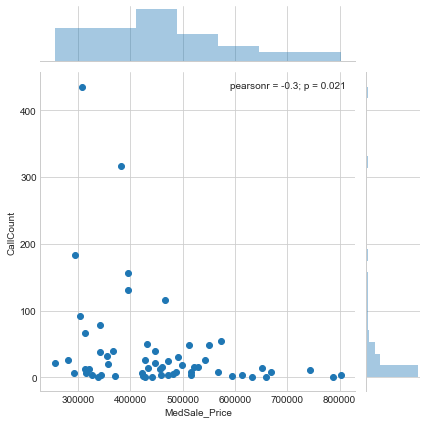

In [37]:
sns.jointplot(DataReduce['MedSale_Price'],DataReduce['CallCount'])

Example:

In [38]:
from geopy.geocoders import Nominatim
import socket
socket.getaddrinfo('127.0.0.1', 8080)
geolocator = Nominatim()

In [39]:
#latitude=Blue['Latitude'][11]
#longitude=Blue['Longitude'][11]
#locString=(latitude,longitude)
#location=geolocator.reverse(locString, timeout=10)
#print(location.raw['address'])

In [40]:
def geoLocate(dataframe):
    '''
    This piece of code will take a dataframe with latitude and longitude columns ...
    ...and return the dataframe with address information.
    '''   
    
    import time
    postal=[]
    county=[]
    house_number=[]
    road=[]
    city=[]
    suburb=[]
    neighborhood=[]
    station=[]
    stop=[]

    for i in range(0,len(dataframe)):

        #condition if the cell is empty
        #print(i)
        latitude=dataframe['Latitude'][i]
        longitude=dataframe['Longitude'][i]
        locString=(latitude,longitude)
        location=geolocator.reverse(locString, timeout=10)
        keys=location.raw['address'].keys()

        time.sleep(1)
        #print(location.raw['address'])
            #neighbourhood
        if 'neighbourhood' in keys:
            neighborhood.append(location.raw['address']['neighbourhood'])
        else:        
            neighborhood.append('None')
        #suburb    
        if 'suburb' in keys:
            suburb.append(location.raw['address']['suburb'])
        else:        
            suburb.append('None')  
        #Postal    
        if 'postcode' in keys:
            postal.append(location.raw['address']['postcode'])
        else:        
            postal.append('None')         
        #county    
        if 'county' in keys:
            county.append(location.raw['address']['county'])
        else:        
            county.append('None')    
        #house_number    
        if 'house_number' in keys:
            house_number.append(location.raw['address']['house_number'])
        else:        
            house_number.append('None')    
        #road    
        if 'road' in keys:
            road.append(location.raw['address']['road'])
        else:        
            road.append('None')  
        #city    
        if 'city' in keys:
            city.append(location.raw['address']['city'])
        else:        
            city.append('None')  
        #station    
        if 'bus_station' in keys:
            station.append(location.raw['address']['bus_station'])
        else:        
            station.append('None') 
        #stop    
        if 'bus_stop' in keys:
            stop.append(location.raw['address']['bus_stop'])
        else:        
            stop.append('None')  


    dataframe['house_number']=house_number
    dataframe['road']=road
    dataframe['postal']=postal
    dataframe['city']=city
    dataframe['county']=county
    dataframe['hood']=neighborhood
    dataframe['burb']=suburb
    dataframe['station']=station
    dataframe['stop']=stop

    return dataframe

In [41]:
url='https://trimet.org/schedules/w/t1090_0.htm'
#webbrowser.open(url)

In [42]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Red=pd.read_csv(location+'Red.csv',delimiter=',')
Red=Red.T
Red.reset_index(inplace=True)
#Red=Red.iloc[:,:2]
Red.columns=['Stops', 'StopID','Latitude','Longitude']
Red['Stops']=Red.Stops.str.replace('TC MAX Station','')
Red['Stops']=Red.Stops.str.replace('MAX Station','')
Red['StopID']=Red.StopID.str.replace('Stop ID','')
Red['Line']='Red'
Red

,Stops,StopID,Latitude,Longitude,Line
0,Beaverton,9821,45.49139,-122.801704,Red
1,Sunset,9969,45.510323,-122.78137,Red
2,Washington Park,10120,45.510694,-122.717424,Red
3,Providence Park,9758,45.521603,-122.689806,Red
4,Pioneer Square South,8334,45.518504,-122.679146,Red
5,Rose Quarter,8340,45.530260,-122.665532,Red
6,Hollywood/NE 42nd Ave,8344,45.533083,-122.621067,Red
7,Gateway/NE 99th Ave,8347,45.530667,-122.563545,Red
8,Portland Int'l Airport,10579,45.587752,-122.593062,Red


In [43]:
#Get address info from Latitude and Longitude
Red=geoLocate(Red)

In [44]:
url='https://trimet.org/schedules/w/t1090_0.htm'
#webbrowser.open(url)

In [45]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Blue=pd.read_csv(location+'Blue.csv',delimiter=',')
Blue=Blue.T
Blue.reset_index(inplace=True)
Blue=Blue.iloc[:,:5]
Blue.columns=['Stops', 'StopID','Address','Latitude','Longitude']
Blue=Blue[['Stops', 'StopID','Latitude','Longitude']]
Blue['Stops']=Blue.Stops.str.replace('TC MAX Station','')
Blue['Stops']=Blue.Stops.str.replace('MAX Station','')
Blue['StopID']=Blue.StopID.str.replace('Stop ID','')
Blue['Line']='Blue'
Blue

,Stops,StopID,Latitude,Longitude,Line
0,Hatfield Government Center,9848,45.522248,-122.991068,Blue
1,Fair Complex/Hillsboro Airport MAX Stn,9838,45.527018,-122.946175,Blue
2,Willow Creek/SW 185th Ave,9831,45.517122,-122.869931,Blue
3,Elmonica/SW 170th Ave,9830,45.509985,-122.851476,Blue
4,Beaverton,9821,45.491500,-122.801690,Blue
5,Sunset,9969,45.510421,-122.781060,Blue
6,Washington Park,10120,45.510818,-122.716308,Blue
7,Providence Park,9758,45.521345,-122.689877,Blue
8,Pioneer Square South,8334,45.518554,-122.679118,Blue
9,Rose Quarter,8340,45.530273,-122.665581,Blue


In [46]:
Blue=geoLocate(Blue)

In [47]:
url='https://trimet.org/schedules/w/t1200_0.htm'
#webbrowser.open(url)

In [48]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Green=pd.read_csv(location+'Green.csv',delimiter=',')
Green=Green.T
Green.reset_index(inplace=True)
Green.columns=['Stops', 'StopID','Address','junk','Latitude','Longitude']
Green=Green[['Stops','StopID','Latitude','Longitude']]
Green['Stops']=Green.Stops.str.replace('TC MAX Station','')
Green['Stops']=Green.Stops.str.replace('MAX Station','')
Green['StopID']=Green.StopID.str.replace('Stop ID','')
Green['Line']='Green'
Green

,Stops,StopID,Latitude,Longitude,Line
0,PSU South/SW 6th & College MAX Stn,10293,45.509684,-122.683614,Green
1,Pioneer Courthouse/SW 6th Ave MAX Stn,7777,45.518979,-122.678566,Green
2,Union Station/NW 6th & Hoyt MAX Stn,7763,45.527254,-122.676528,Green
3,Rose Quarter,8340,45.530261,-122.665557,Green
4,Hollywood/NE 42nd Ave,8344,45.532937,-122.621140,Green
5,Gateway/NE 99th Ave,8347,45.530646,-122.563587,Green
6,Lents/SE Foster Rd,13128,45.480559,-122.566831,Green
7,Clackamas Town Center,13132,45.436164,-122.567568,Green


In [49]:
Green=geoLocate(Green)

In [50]:
url='https://trimet.org/schedules/w/t1190_1.htm'
#webbrowser.open(url)

In [51]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Yellow=pd.read_csv(location+'Yellow.csv',delimiter=',')
Yellow=Yellow.T
Yellow.reset_index(inplace=True)
#Yellow=Yellow.iloc[:,:2]
Yellow.columns=['Stops', 'StopID','Latitude','Longitude']
Yellow['Stops']=Yellow.Stops.str.replace('TC MAX Station','')
Yellow['Stops']=Yellow.Stops.str.replace('MAX Station','')
Yellow['StopID']=Yellow.StopID.str.replace('Stop ID','')
Yellow['Line']='Yellow'
Yellow

,Stops,StopID,Latitude,Longitude,Line
0,Expo Center,11498,45.605376,-122.685745,Yellow
1,N Lombard,11501,45.576608,-122.682183,Yellow
2,N Prescott St,11504,45.555376,-122.682303,Yellow
3,Interstate/Rose Quarter,11507,45.530373,-122.666249,Yellow
4,Union Station/NW 5th & Glisan MAX Stn,7601,45.526735,-122.675603,Yellow
5,Pioneer Place/SW 5th Ave,7646,45.518265,-122.677927,Yellow
6,PSU South/SW 5th & Jackson MAX Stn,7606,45.508985,-122.682999,Yellow


In [52]:
Yellow=geoLocate(Yellow)

In [53]:
url='https://trimet.org/schedules/w/t1290_0.htm'
#webbrowser.open(url)

In [54]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Orange=pd.read_csv(location+'Orange.csv',delimiter=',')
Orange=Orange.T
Orange.reset_index(inplace=True)
#Orange=Orange.iloc[:,:2]
Orange.columns=['Stops', 'StopID','Latitude','Longitude']
Orange['Stops']=Orange.Stops.str.replace('TC MAX Station','')
Orange['Stops']=Orange.Stops.str.replace('MAX Station','')
Orange['StopID']=Orange.StopID.str.replace('Stop ID','')
Orange['Line']='Orange'
Orange

,Stops,StopID,Latitude,Longitude,Line
0,Union Station/NW 5th & Glisan MAX Stn,7601,45.526742,-122.675607,Orange
1,Pioneer Place/SW 5th Ave,7646,45.518268,-122.677929,Orange
2,PSU South/SW 5th & Jackson MAX Stn,7606,45.508985,-122.682998,Orange
3,South Waterfront/SW Moody,13711,45.502712,-122.671141,Orange
4,OMSI/SE Water,13712,45.506481,-122.662586,Orange
5,SE 17th Ave & Holgate Blvd,13715,45.491162,-122.648456,Orange
6,SE Tacoma/Johnson Creek,13717,45.46301,-122.637845,Orange
7,Milwaukie/Main St,13718,45.441438,-122.639819,Orange
8,SE Park Ave,13720,45.430739,-122.635065,Orange


In [55]:
Orange=geoLocate(Orange)

In [59]:
LinesKey=Red.append(Blue).append(Green).append(Yellow).append(Orange)
LinesKey.reset_index(inplace=True,drop=True)
LinesKey['burb'].replace('Portland Downtown','Downtown',inplace=True)
LinesKey['burb'].replace('Hosford-Abernethy','Hosford Abernethy',inplace=True)
LinesKey['burb'].replace('Old Town','Old Town/Chinatown',inplace=True)
LinesKey['burb'].replace('Ardenwald-Johnson Creek','Ardenwald',inplace=True)
LinesKey['burb'].replace('Waverly Heights','Ardenwald',inplace=True)
LinesKey.drop('hood',axis=1,inplace=True)
LinesKey.rename(index=str,columns={"burb": "Hood"},inplace=True) 
LinesKey

,Stops,StopID,Latitude,Longitude,Line,house_number,road,postal,city,county,Hood,station,stop
0,Beaverton,9821,45.49139,-122.801704,Red,None,None,97005,Beaverton,Washington County,None,None,None
1,Sunset,9969,45.510323,-122.78137,Red,None,None,97005,Beaverton,Washington County,West Slope,Sunset Transit Center,Sunset Transit Center
2,Washington Park,10120,45.510694,-122.717424,Red,4033,None,97221,Portland,Multnomah County,Arlington Heights,None,MAX Station/Oregon Zoo
3,Providence Park,9758,45.521603,-122.689806,Red,817,Southwest 17th Avenue,97205,Portland,Multnomah County,Goose Hollow,None,None
4,Pioneer Square South,8334,45.518504,-122.679146,Red,None,None,97202,Portland,Multnomah County,Downtown,None,None
5,Rose Quarter,8340,45.530260,-122.665532,Red,None,Northeast Wheeler Avenue,97217,Portland,Multnomah County,Lloyd District,None,None
6,Hollywood/NE 42nd Ave,8344,45.533083,-122.621067,Red,4030,Northeast Halsey Street,97232,Portland,Multnomah County,Hollywood,None,None
7,Gateway/NE 99th Ave,8347,45.530667,-122.563545,Red,None,Northeast Multnomah Street,97220,Portland,Multnomah County,Hazelwood,None,None
8,Portland Int'l Airport,10579,45.587752,-122.593062,Red,None,None,97218,Portland,Multnomah County,None,None,None
9,Hatfield Government Center,9848,45.522248,-122.991068,Blue,None,None,97123-4201,Hillsboro,Washington County,None,None,None


In [61]:
#Save the dataset
LinesKey.to_pickle('LinesKey.pickle')

In [62]:
LinesKey=pd.read_pickle('LinesKey.pickle')

In [63]:
LinesReduced=LinesKey[['Line','Hood']]
LinesReduced.head()

,Line,Hood
0,Red,None
1,Red,West Slope
2,Red,Arlington Heights
3,Red,Goose Hollow
4,Red,Downtown


In [64]:
BurbHoodSet=set(LinesKey.Hood)
BurbHoodList=list(BurbHoodSet)
DataReduceSet=set(SubCalls.Hood)
BurbHoodSet.difference(DataReduceSet)

{'Elmonica',
 'Harmony Point',
 'Hosford Abernethy',
 'Lloyd District',
 'Milwaukie Heights',
 'None',
 'Orenco',
 'Rockwood',
 'Twelvemile Corner',
 'West Slope'}

In [65]:
CallsLines=SubCalls.merge(LinesReduced,how='left',on='Hood')
CallsLines.drop('CallMatches',axis=1,inplace=True)
CallsLines['Line']=CallsLines.Line.fillna('NoLine')
CallsLines=CallsLines.drop_duplicates()
CallsLines.head()

,Hood,CallCount,Line
0,Arbor Lodge,39,Yellow
1,Ardenwald,20,Orange
3,Argay,2,NoLine
4,Arlington Heights,2,Red
5,Arlington Heights,2,Blue


In [66]:
temp=pd.DataFrame(CallsLines['Line'])
for x in temp.Line.unique():
    temp[x]=(temp.Line==x).astype(int)
CallsLines=pd.concat([CallsLines,temp],axis=1)
CallsLines.drop('Line',axis=1,inplace=True)
PriceCallLine=CallsLines[['Hood','Yellow','Orange','NoLine','Red','Blue','Green']].merge(DataReduce,how='left',on='Hood')
PriceCallLine=PriceCallLine[PriceCallLine['NoLine']<1][['Hood','MedSale_Price']]
PriceCallLine=PriceCallLine.drop_duplicates()

In [67]:
LineHoodDF=CallsLines[CallsLines['NoLine']<1].groupby('Hood').sum()
LineHoodDF.reset_index(inplace=True)
LineHoodDF['CountLines']=LineHoodDF.loc[:,'Yellow':'Green'].sum(axis=1)
LineHoodDF['CallPerLine']=LineHoodDF['CallCount']/LineHoodDF['CountLines']
LineHoodDF=LineHoodDF.merge(PriceCallLine,how='left',on='Hood')

In [68]:
RowTotal=['Total',LineHoodDF.CallCount.sum(), \
                     LineHoodDF['CallCount'][LineHoodDF['Yellow']==1].sum(),\
                     LineHoodDF['CallCount'][LineHoodDF['Orange']==1].sum(),\
                     LineHoodDF.NoLine.sum(),
                     LineHoodDF['CallCount'][LineHoodDF['Red']==1].sum(),\
                     LineHoodDF['CallCount'][LineHoodDF['Blue']==1].sum(),\
                     LineHoodDF['CallCount'][LineHoodDF['Green']==1].sum(),\
                     LineHoodDF.CountLines.max(),LineHoodDF.CallPerLine.sum(),LineHoodDF.MedSale_Price.sum()]

#LineHoodDF.loc[len(LineHoodDF)]

In [69]:
RowAverage=['PerStop',\
            int(4990/13), \
            int(2639/5),\
            int(2426/5),\
            int(3649/5),\
            int(3649/5),\
            int(4313/5),\
            5,\
            int(1893.0/13),\
            int(3117200/8)]

In [70]:
LineHoodDF.loc[len(LineHoodDF)]=RowTotal
LineHoodDF.drop('NoLine',inplace=True,axis=1)
LineHoodDF.loc[len(LineHoodDF)]=RowAverage

In [71]:
LineHoodDF

,Hood,CallCount,Yellow,Orange,Red,Blue,Green,CountLines,CallPerLine,MedSale_Price
0,Arbor Lodge,39,1,0,0,0,0,1,39.0,447400.0
1,Ardenwald,20,0,1,0,0,0,1,20.0,NaN
2,Arlington Heights,4,0,0,1,1,0,2,2.0,NaN
3,Brooklyn,50,0,1,0,0,0,1,50.0,431000.0
4,Downtown,1580,1,1,1,1,1,5,316.0,381800.0
5,Goose Hollow,262,0,0,1,1,0,2,131.0,395200.0
6,Hazelwood,1305,0,0,1,1,1,3,435.0,307000.0
7,Hollywood,498,0,0,1,1,1,3,166.0,NaN
8,Kenton,157,1,0,0,0,0,1,157.0,394400.0
9,Lents,183,0,0,0,0,1,1,183.0,294400.0


In [110]:
plotDF=LineHoodDF.iloc[14:,2:7].T
plotDF.rename(index=str,columns={14:'PerStop'},inplace=True)
#plotDF.plot(kind='bar',figsize=(6,8),cmap='seismic',legend=False)

In [111]:
plotDF
plotDF.reset_index(inplace=True)

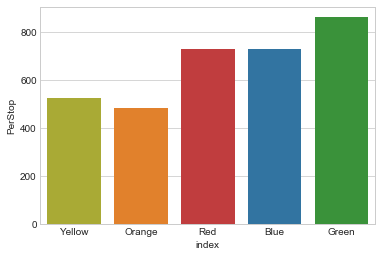

In [124]:
import seaborn as sns
sns.set_style("whitegrid")

palette ={"Yellow":"C8","Orange":"C1","Red":"C3", "Blue":"C0", "Green":"C2"}

ax = sns.barplot(x="index", y="PerStop", data=plotDF, palette=palette)


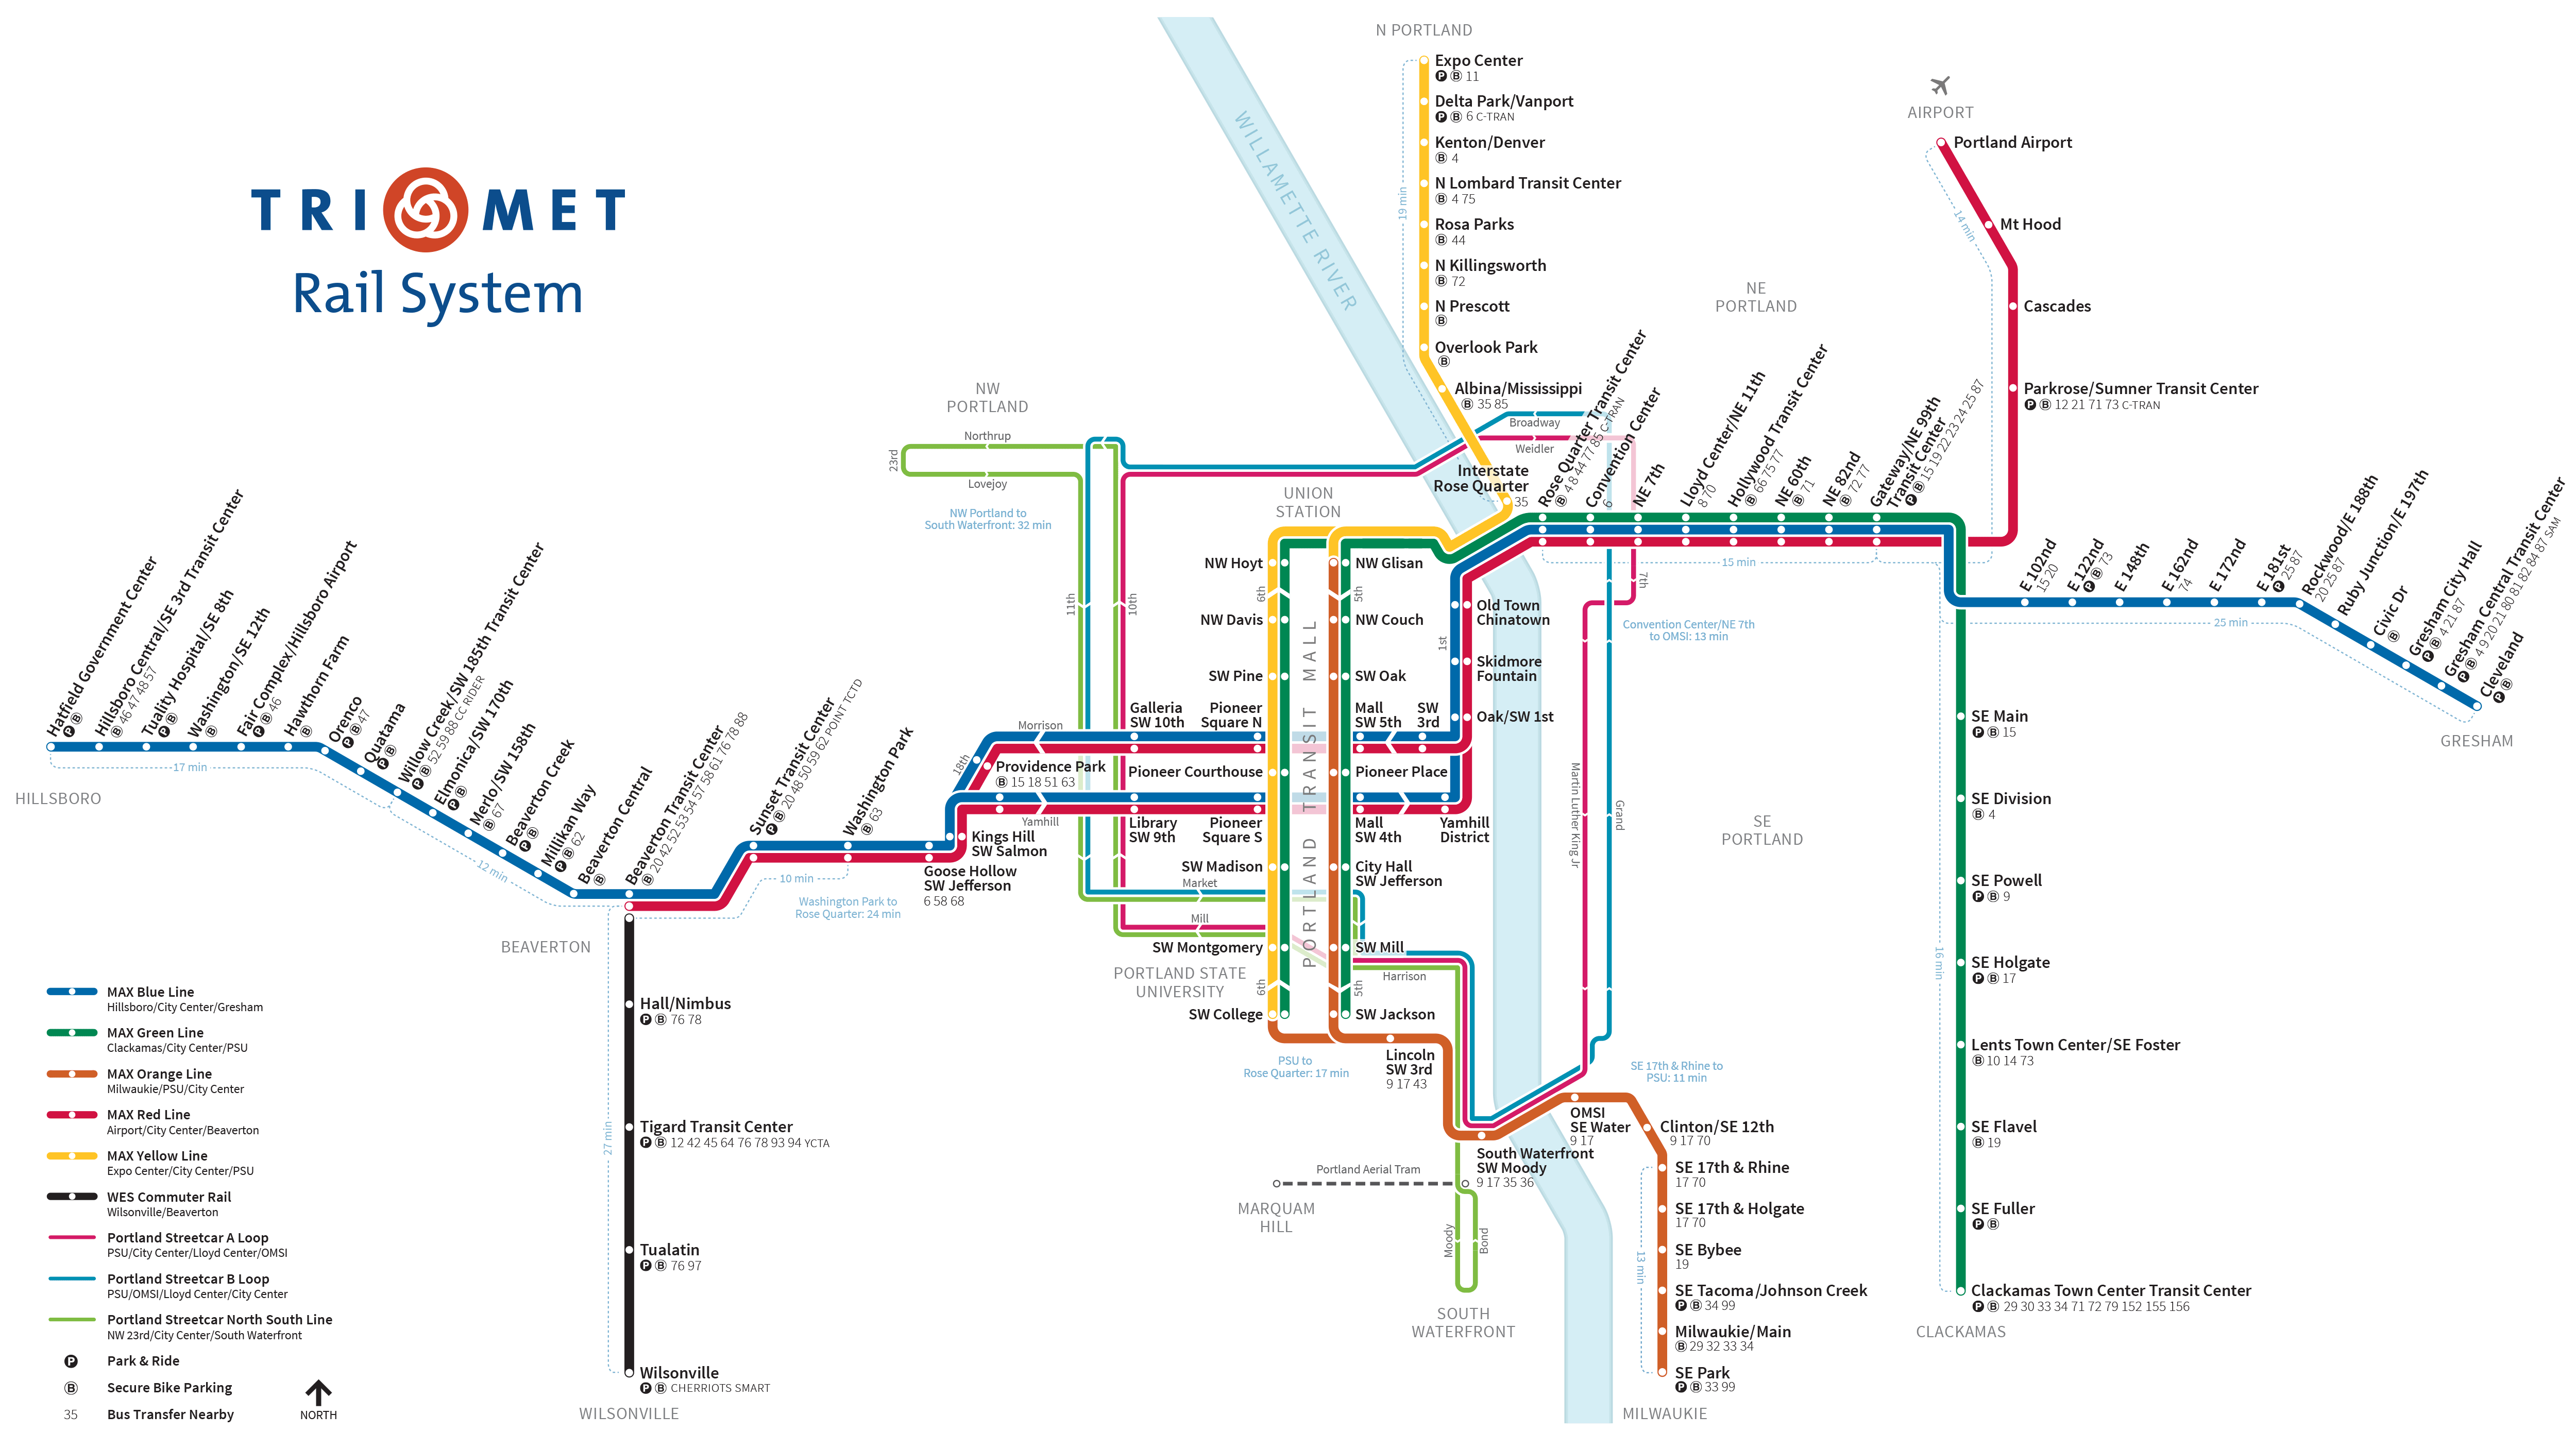

In [75]:
Image("railsystem.png")

Trimet Events
---------------

In [487]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
trimEventMonth=pd.read_csv(location+'events_month.csv',delimiter=',')
trimEventMonth.head()

,bearing,delay,event_timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,tripID,vehicle_id,vehicle_location_latitude,vehicle_location_longitude
0,306,-430,2017-01-01 08:00:03,9819,24,9827,25,6999629,251,45.502307,-122.836712
1,20,-113,2017-01-01 08:00:04,13720,1,13721,2,7003700,405,45.439829,-122.640634
2,91,-17,2017-01-01 08:00:22,9848,1,9846,2,6998908,306,45.521351,-122.986448
3,358,-56,2017-01-01 08:00:23,9299,6,7763,7,7000472,420,45.526400,-122.676568
4,98,-729,2017-01-01 08:00:23,8357,46,8359,47,6998905,118,45.501997,-122.419650


In [359]:
trimEventMonth.sort_values(by='event_timestamp',ascending=False).head()

,bearing,delay,event_timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,tripID,vehicle_id,vehicle_location_latitude,vehicle_location_longitude
164440,301,15,2017-01-31 23:59:59,8362,5,8363,6,7127635,312,45.516942,-122.462215
164439,306,2,2017-01-31 23:59:59,9819,36,9827,37,7127629,411,45.505379,-122.842342
164438,350,0,2017-01-31 23:59:58,13132,24,13132,1,7129550,314,45.436024,-122.567887
164437,352,-132,2017-01-31 23:59:58,11508,8,11509,9,7128192,417,45.538771,-122.674562
164436,201,-6,2017-01-31 23:59:57,9820,22,10117,23,7126629,116,45.518961,-122.692238


In [360]:
trimEventMonth['event_timestamp'].min()

'2017-01-01 08:00:03'

In [361]:
trimEventMonth['event_timestamp'].max()

'2017-01-31 23:59:59'

Trimet Vehicle
----------------

In [3]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
trimVehicle=pd.read_csv(location+'vehicle-data-sample.csv',delimiter=',')
trimVehicle=trimVehicle.iloc[:,1:]
trimVehicle=trimVehicle[trimVehicle['type']=='rail']
trimVehicle.head()

,bearing,blockID,city,delay,device_id,direction,event_timestamp,expires,garage,inCongestion,...,signMessageLong,state,system,tripID,type,vehicle_id,vehicle_location_latitude,vehicle_location_longitude,vehicle_location_latitude.1,vehicle_location_longitude.1
0,147,9066,portland,-31,317,1,1483257600,2017-01-01T08:08:31,RUBY,False,...,MAX Orange Line to Milwaukie,oregon,trimet,7004120.0,rail,317,45.483499,-122.643220,45.483499,-122.643220
3,20,9069,portland,-113,413,0,1483257604,2017-01-01T08:07:53,RUBY,False,...,MAX Orange Line to City Center/Expo Center,oregon,trimet,7003700.0,rail,413,45.439829,-122.640634,45.439829,-122.640634
14,91,9001,portland,-17,110,0,1483257622,2017-01-01T08:06:47,RUBY,False,...,MAX Blue Line to Gresham,oregon,trimet,6998908.0,rail,110,45.521351,-122.986448,45.521351,-122.986448
15,358,9067,portland,-56,420,0,1483257622,2017-01-01T08:10:26,RUBY,False,...,MAX Yellow Line to Expo Center,oregon,trimet,7000472.0,rail,420,45.526400,-122.676568,45.526400,-122.676568
16,358,9067,portland,-56,412,0,1483257622,2017-01-01T08:10:26,RUBY,False,...,MAX Yellow Line to Expo Center,oregon,trimet,7000472.0,rail,412,45.526400,-122.676568,45.526400,-122.676568


Example of GeoCoding from Latitude and Longitude
========================
GeoCoding 
---------

**Example Data**

In [728]:
trimEventMonth[:1]

,bearing,delay,event_timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,tripID,vehicle_id,vehicle_location_latitude,vehicle_location_longitude
0,306,-430,2017-01-01 08:00:03,9819,24,9827,25,6999629,251,45.502307,-122.836712


The latitude and longitude of the 4th row of the dataset

In [729]:
trimEventMonth['vehicle_location_latitude'][3],trimEventMonth['vehicle_location_longitude'][3]

(45.526400000000002, -122.676568)

In [730]:
latitude=trimEventMonth['vehicle_location_latitude'][3]
longitude=trimEventMonth['vehicle_location_longitude'][3]
locString=(latitude,longitude)

In [731]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location=geolocator.reverse(locString, timeout=10)
print(location.raw['address'])

{'house_number': '414', 'road': 'Northwest 6th Avenue', 'neighbourhood': 'Chinatown', 'suburb': 'Old Town', 'city': 'Portland', 'county': 'Multnomah County', 'state': 'Oregon', 'postcode': '97209', 'country': 'United States of America', 'country_code': 'us'}


See the keys in the dictionary

In [732]:
location.raw['address'].keys()

dict_keys(['house_number', 'road', 'neighbourhood', 'suburb', 'city', 'county', 'state', 'postcode', 'country', 'country_code'])

Indexing dictionary key (neighbourhood)

In [733]:
location.raw['address']['neighbourhood']

'Chinatown'

Indexing dictionary key (suburb)

In [734]:
location.raw['address']['suburb']

'Old Town'

In [735]:
addyKey=pd.DataFrame(data=trimEventMonth, columns=['vehicle_location_longitude','vehicle_location_latitude'])
addyKey['hood']=None

In [736]:
addyKey.head(n=3)

,vehicle_location_longitude,vehicle_location_latitude,hood
0,-122.836712,45.502307,None
1,-122.640634,45.439829,None
2,-122.986448,45.521351,None


In [737]:
test=addyKey.head().copy()
test.head()
#print(len(test))

,vehicle_location_longitude,vehicle_location_latitude,hood
0,-122.836712,45.502307,None
1,-122.640634,45.439829,None
2,-122.986448,45.521351,None
3,-122.676568,45.526400,None
4,-122.419650,45.501997,None


In [738]:
import time
#Create Lists for Populating
latList=[]
longList=[]
neighborhood=[]
suburb=[]
postal=[]

#modify range    
for i in range(0,len(test)):
    #condition if the cell is empty
    if test['hood'][i]==None:
        print(i)
        latitude=test['vehicle_location_latitude'][i]
        longitude=test['vehicle_location_longitude'][i]
        locString=(latitude,longitude)
        location=geolocator.reverse(locString, timeout=10)
        keys=location.raw['address'].keys()
        
        time.sleep(1)
        #print(location.raw['address'])
            #neighbourhood
        if 'neighbourhood' in keys:
            neighborhood.append(location.raw['address']['neighbourhood'])
        else:        
            neighborhood.append('None')
        #suburb    
        if 'suburb' in keys:
            suburb.append(location.raw['address']['suburb'])
        else:        
            suburb.append('None')  
        #Postal    
        if 'postcode' in keys:
            postal.append(location.raw['address']['postcode'])
        else:        
            postal.append('None')       
    else:
        continue

test['hood']=neighborhood
test['burb']=suburb
test['postal']=postal
test

0
1
2
3
4


,vehicle_location_longitude,vehicle_location_latitude,hood,burb,postal
0,-122.836712,45.502307,None,Huber,97003
1,-122.640634,45.439829,Ardenwald,Waverly Heights,97222
2,-122.986448,45.521351,Glencoe Estates,None,97123-4201
3,-122.676568,45.526400,Chinatown,Old Town,97209
4,-122.419650,45.501997,None,Twelvemile Corner,97030
